In [192]:
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, FunctionTransformer
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import permutation_importance



# EDA

In [193]:
df = pd.read_csv('data/student_mental_health_survey.csv')
df.head()

,Age,Course,Gender,CGPA,Stress_Level,Depression_Score,Anxiety_Score,Sleep_Quality,Physical_Activity,Diet_Quality,Social_Support,Relationship_Status,Substance_Use,Counseling_Service_Use,Family_History,Chronic_Illness,Financial_Stress,Extracurricular_Involvement,Semester_Credit_Load,Residence_Type
0,25,Others,Male,3.56,3,3,2,Good,Moderate,Good,Moderate,Married,Never,Never,No,No,2,Moderate,17,On-Campus
1,24,Engineering,Female,2.44,0,3,0,Average,Low,Average,Low,Single,Occasionally,Occasionally,No,No,3,Low,27,On-Campus
2,19,Business,Female,3.74,4,0,3,Good,Low,Average,Moderate,In a Relationship,Never,Occasionally,No,No,4,High,15,On-Campus
3,19,Computer Science,Male,3.65,2,1,0,Average,Low,Average,Moderate,Single,NaN,Never,No,No,4,Moderate,20,Off-Campus
4,18,Business,Male,3.40,3,3,4,Good,Low,Average,High,Married,Never,Never,No,Yes,0,High,23,On-Campus


In [194]:
df.shape

(7022, 20)

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          7022 non-null   int64  
 1   Course                       7022 non-null   object 
 2   Gender                       7022 non-null   object 
 3   CGPA                         6309 non-null   float64
 4   Stress_Level                 7022 non-null   int64  
 5   Depression_Score             7022 non-null   int64  
 6   Anxiety_Score                7022 non-null   int64  
 7   Sleep_Quality                7022 non-null   object 
 8   Physical_Activity            7022 non-null   object 
 9   Diet_Quality                 7022 non-null   object 
 10  Social_Support               7022 non-null   object 
 11  Relationship_Status          7022 non-null   object 
 12  Substance_Use                6307 non-null   object 
 13  Counseling_Service

In [196]:
df.columns

Index(['Age', 'Course', 'Gender', 'CGPA', 'Stress_Level', 'Depression_Score',
       'Anxiety_Score', 'Sleep_Quality', 'Physical_Activity', 'Diet_Quality',
       'Social_Support', 'Relationship_Status', 'Substance_Use',
       'Counseling_Service_Use', 'Family_History', 'Chronic_Illness',
       'Financial_Stress', 'Extracurricular_Involvement',
       'Semester_Credit_Load', 'Residence_Type'],
      dtype='object')

In [197]:
missing_values = df.isnull().sum()
missing_values

Age                              0
Course                           0
Gender                           0
CGPA                           713
Stress_Level                     0
Depression_Score                 0
Anxiety_Score                    0
Sleep_Quality                    0
Physical_Activity                0
Diet_Quality                     0
Social_Support                   0
Relationship_Status              0
Substance_Use                  715
Counseling_Service_Use           0
Family_History                   0
Chronic_Illness                  0
Financial_Stress                 0
Extracurricular_Involvement      0
Semester_Credit_Load             0
Residence_Type                   0
dtype: int64

In [198]:
print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (7022, 20)
fraction of missing values in features:
CGPA             0.101538
Substance_Use    0.101823
dtype: float64
data types of the features with missing values:
CGPA             float64
Substance_Use     object
dtype: object
fraction of points with missing values: 0.10338934776416975


In [199]:
df['Substance_Use'].unique()

array(['Never', 'Occasionally', nan, 'Frequently'], dtype=object)

In [200]:
df[['Age', 'CGPA', 'Semester_Credit_Load']].describe()

,Age,CGPA,Semester_Credit_Load
count,7022.000000,6309.000000,7022.000000
mean,23.003418,3.488719,22.010538
std,3.853978,0.287665,4.358380
min,18.000000,2.440000,15.000000
25%,20.000000,3.290000,18.000000
50%,22.000000,3.500000,22.000000
75%,25.000000,3.690000,26.000000
max,35.000000,4.000000,29.000000


### Check the distribution of my target variables

In [201]:
df['Depression_Score'].unique()

array([3, 0, 1, 4, 2, 5])

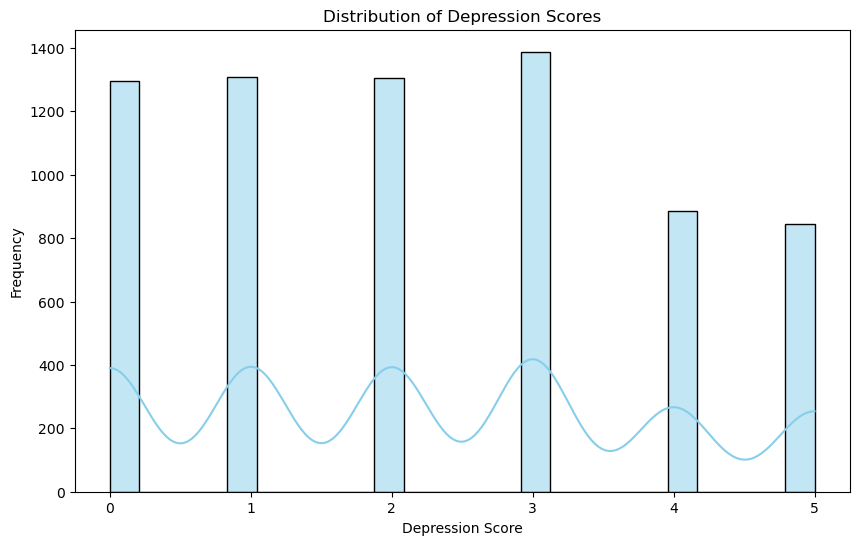

In [221]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Depression_Score', kde=True, color='skyblue')

plt.title('Distribution of Depression Scores')
plt.xlabel('Depression Score')
plt.ylabel('Frequency')
plt.savefig("../DATA1030_Project/figures/distribution_of_depression_score.png", dpi=300)
plt.show()

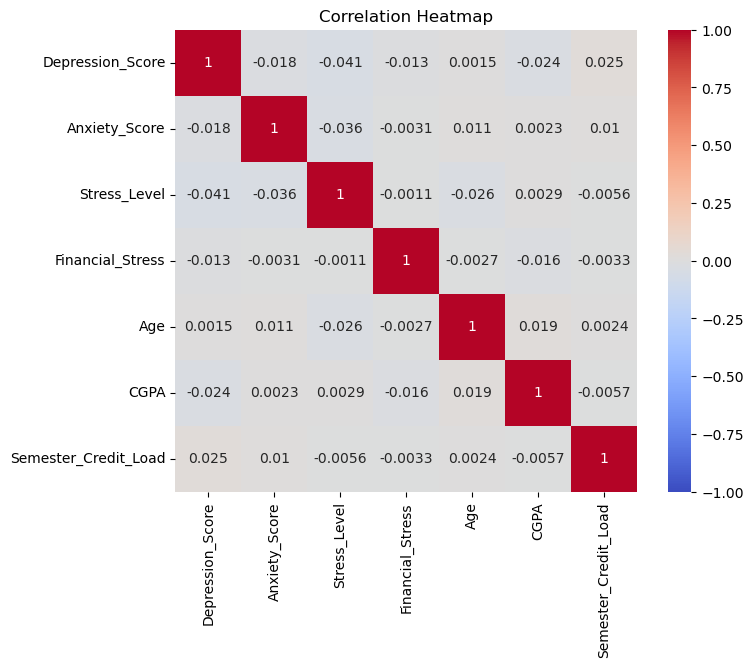

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix using Spearman's method
corr_matrix = df[['Depression_Score', 'Anxiety_Score', 'Stress_Level', 'Financial_Stress', 'Age', 'CGPA', 'Semester_Credit_Load']].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap")
plt.savefig("../DATA1030_Project/figures/correlation_heatmap_between_target_variable_and_numerical_features.png", dpi=300)
plt.show()

#### Distribution of my target variables

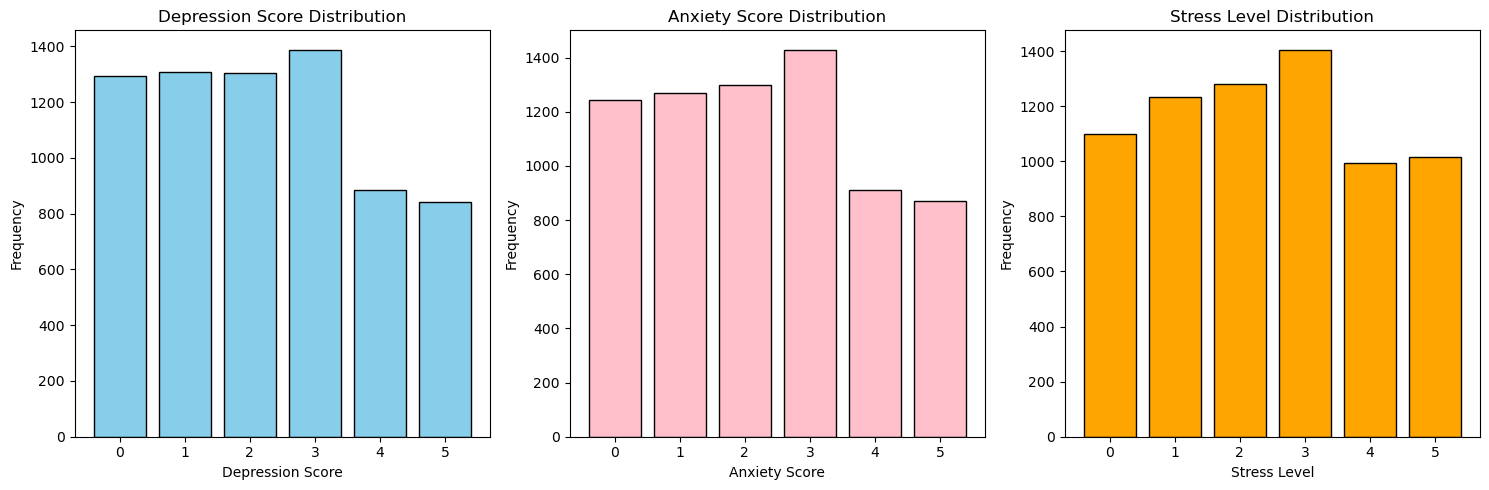

In [223]:
categories = [0,1,2,3,4,5]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].bar(categories, df['Depression_Score'].value_counts().sort_index(), color='skyblue', edgecolor='black')
axes[0].set_title('Depression Score Distribution')
axes[0].set_xlabel('Depression Score')
axes[0].set_ylabel('Frequency')

axes[1].bar(categories, df['Anxiety_Score'].value_counts().sort_index(), color='pink', edgecolor='black')
axes[1].set_title('Anxiety Score Distribution')
axes[1].set_xlabel('Anxiety Score')
axes[1].set_ylabel('Frequency')

axes[2].bar(categories, df['Stress_Level'].value_counts().sort_index(), color='orange', edgecolor='black')
axes[2].set_title('Stress Level Distribution')
axes[2].set_xlabel('Stress Level')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig("../DATA1030_Project/figures/distribution_of_mental_health_data.png", dpi=300)
plt.show()

#### Heatmap for course and my target variables

In [204]:
grouped = df.groupby(['Course', 'Depression_Score']).size().unstack(fill_value=0)
grouped

Depression_Score,0,1,2,3,4,5
Course,,,,,,
Business,143,145,139,149,66,75
Computer Science,47,108,136,197,276,264
Engineering,211,220,218,212,111,100
Law,277,279,269,284,143,133
Medical,461,416,406,412,212,198
Others,156,140,136,134,76,73


In [207]:
standardized_distribution = grouped.div(grouped.sum(axis=1), axis=0)

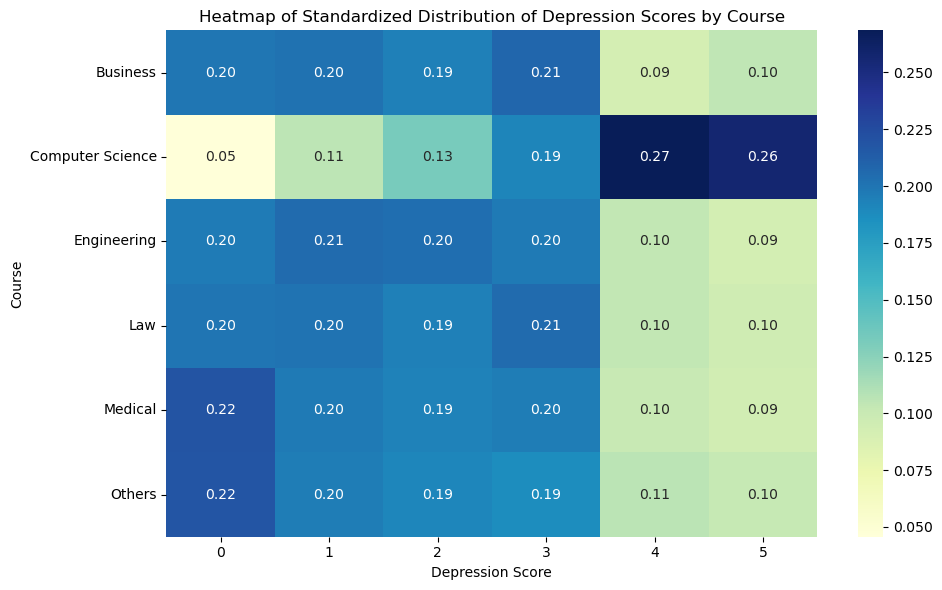

In [208]:
plt.figure(figsize=(10, 6))
sns.heatmap(standardized_distribution, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)

# Customize the plot
plt.title('Heatmap of Standardized Distribution of Depression Scores by Course')
plt.xlabel('Depression Score')
plt.ylabel('Course')
plt.tight_layout()
plt.savefig("../DATA1030_Project/figures/high_res_plot.png", dpi=300)

# Show the plot
plt.show()

#### Boxplot for CGPA and target variables

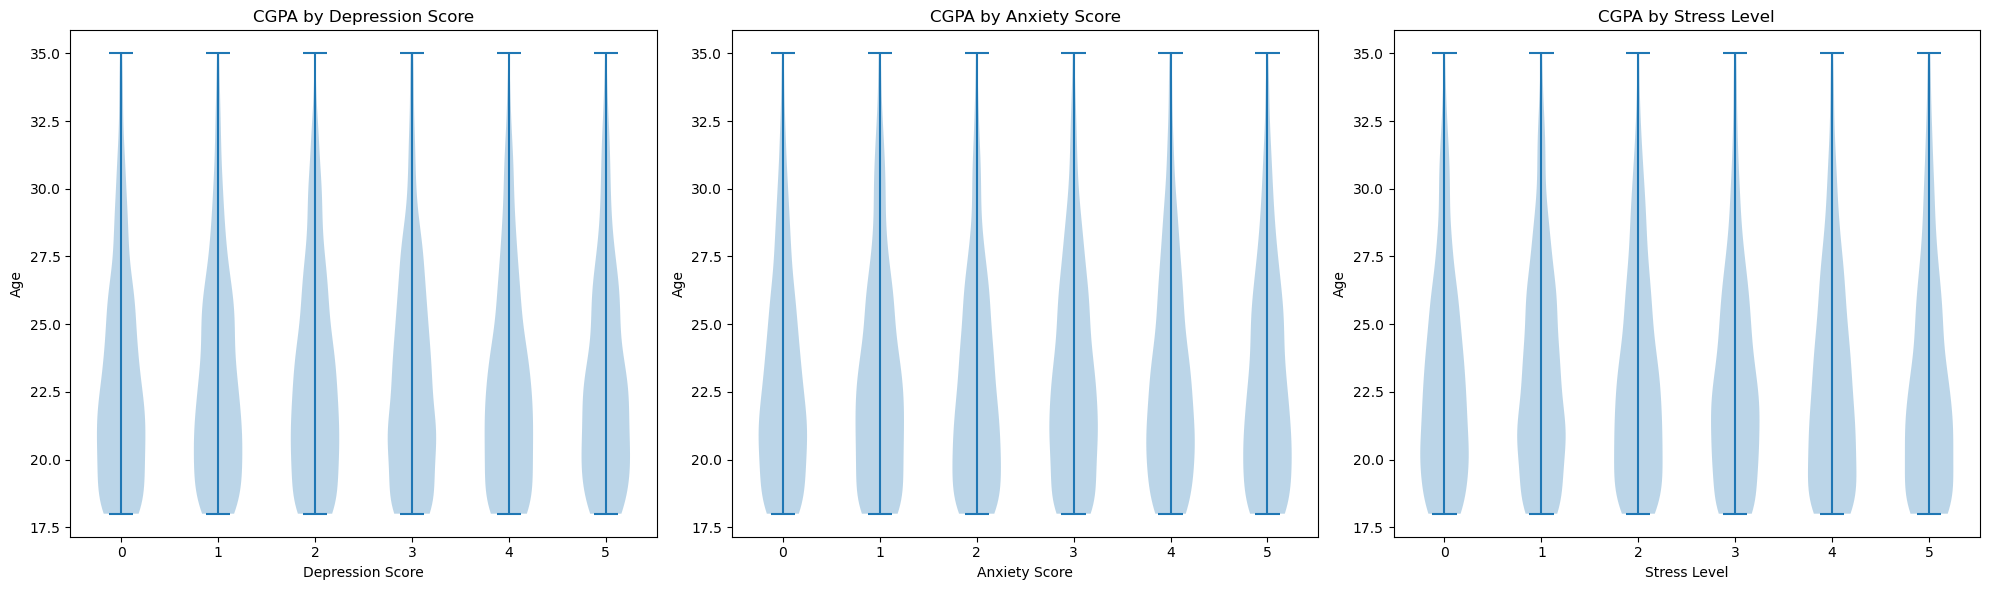

In [224]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
depression_unique = sorted(df['Depression_Score'].unique())
axes[0].violinplot([df['Age'][df['Depression_Score'] == score] for score in depression_unique])
axes[0].set_title('CGPA by Depression Score')
axes[0].set_xlabel('Depression Score')
axes[0].set_ylabel('Age')
axes[0].set_xticks(range(1, len(depression_unique) + 1))
axes[0].set_xticklabels(depression_unique)

anxiety_unique = sorted(df['Anxiety_Score'].unique())
axes[1].violinplot([df['Age'][df['Anxiety_Score'] == score] for score in anxiety_unique])
axes[1].set_title('CGPA by Anxiety Score')
axes[1].set_xlabel('Anxiety Score')
axes[1].set_ylabel('Age')
axes[1].set_xticks(range(1, len(anxiety_unique) + 1))
axes[1].set_xticklabels(anxiety_unique)

stress_unique = sorted(df['Stress_Level'].unique())
axes[2].violinplot([df['Age'][df['Stress_Level'] == score] for score in stress_unique])
axes[2].set_title('CGPA by Stress Level')
axes[2].set_xlabel('Stress Level')
axes[2].set_ylabel('Age')
axes[2].set_xticks(range(1, len(stress_unique) + 1))
axes[2].set_xticklabels(stress_unique)

plt.tight_layout()
plt.savefig("../DATA1030_Project/figures/violin_plot_of_different_scores.png", dpi=300)
plt.show()

In [210]:
onehot_ftrs = ['Gender', 'Relationship_Status', 'Family_History', 'Chronic_Illness', 'Residence_Type'] 
minmax_ftrs = ['Age','CGPA', 'Semester_Credit_Load']
ordinal_ftrs = ['Stress_Level', 'Anxiety_Score', 'Financial_Stress', 'Sleep_Quality', 'Physical_Activity',
                 'Diet_Quality', 'Social_Support', 'Substance_Use', 'Counseling_Service_Use', 'Extracurricular_Involvement']

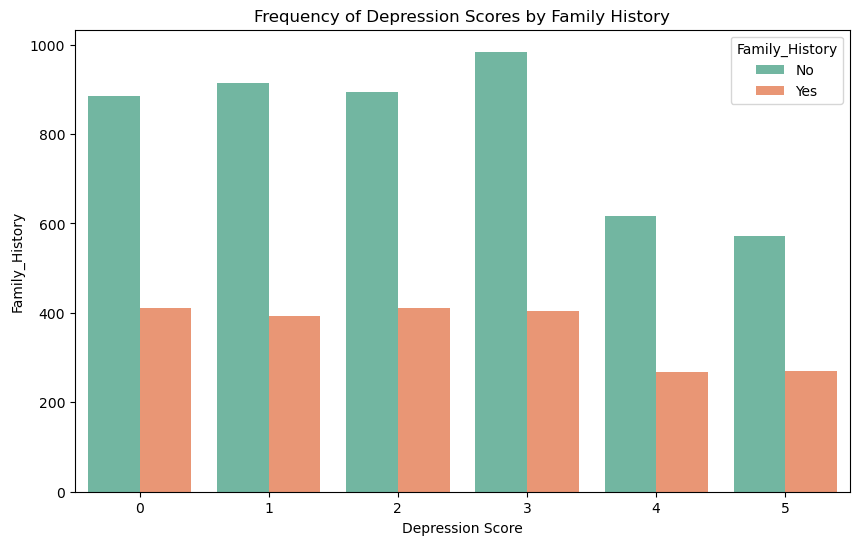

In [225]:
plt.figure(figsize=(10, 6))

# Plot the count of Depression Scores for each Gender
sns.countplot(data=df, x='Depression_Score', hue='Family_History', palette='Set2')

# Add labels and title
plt.title('Frequency of Depression Scores by Family History')
plt.xlabel('Depression Score')
plt.ylabel('Family_History')

# Display the legend and the plot
plt.legend(title='Family_History')
plt.savefig("../DATA1030_Project/figures/depression_scores_by_family_history.png", dpi=300)
plt.show()

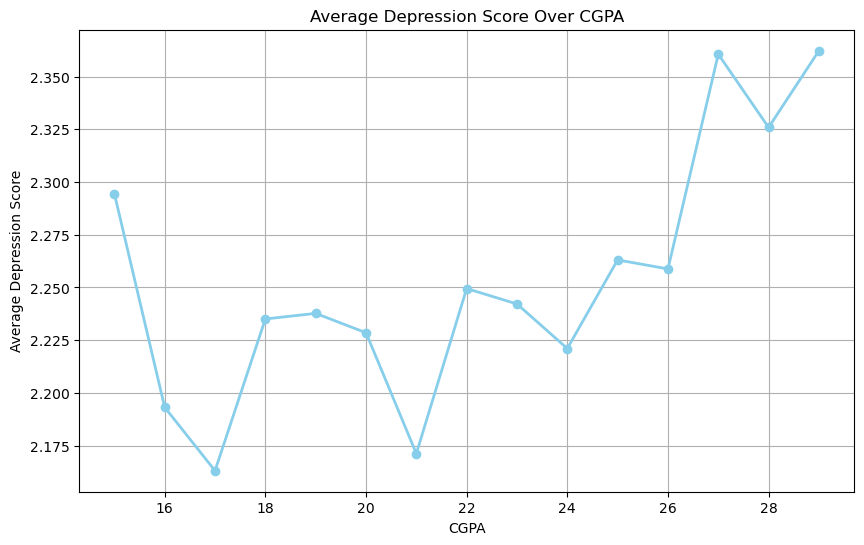

In [226]:
age_depression_mean = df.groupby('Semester_Credit_Load')['Depression_Score'].mean()

# Now, we can create the line plot.
plt.figure(figsize=(10, 6))
plt.plot(age_depression_mean.index, age_depression_mean.values, marker='o', color='skyblue', lw=2)
plt.title('Average Depression Score Over CGPA')
plt.xlabel('CGPA')
plt.ylabel('Average Depression Score')
plt.grid(True)
plt.savefig("../DATA1030_Project/figures/Average_depression_score_over_CGPA.png", dpi=300)
plt.show()

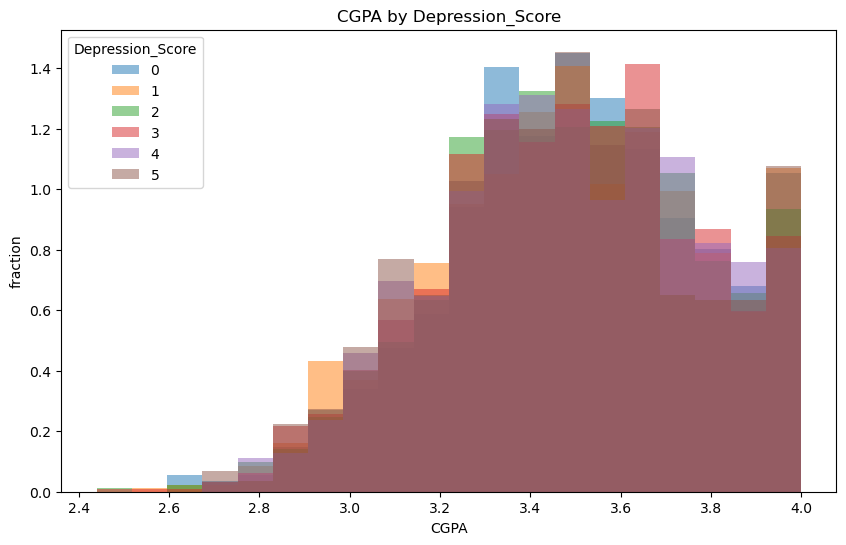

In [227]:
for i in ['Depression_Score']:
    categories = sorted(df[i].unique())
    bin_range = (df['CGPA'].min(),df['CGPA'].max())

    plt.figure(figsize=(10,6))

    for c in categories:
        plt.hist(df[df[i]==c]['CGPA'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
    plt.legend(title = i)
    plt.title('CGPA by ' + i)
    plt.ylabel('fraction')
    plt.xlabel('CGPA')
    plt.savefig("../DATA1030_Project/figures/CGPA_BY_DEPRESSION_SCORE.png", dpi=300)
    plt.show()






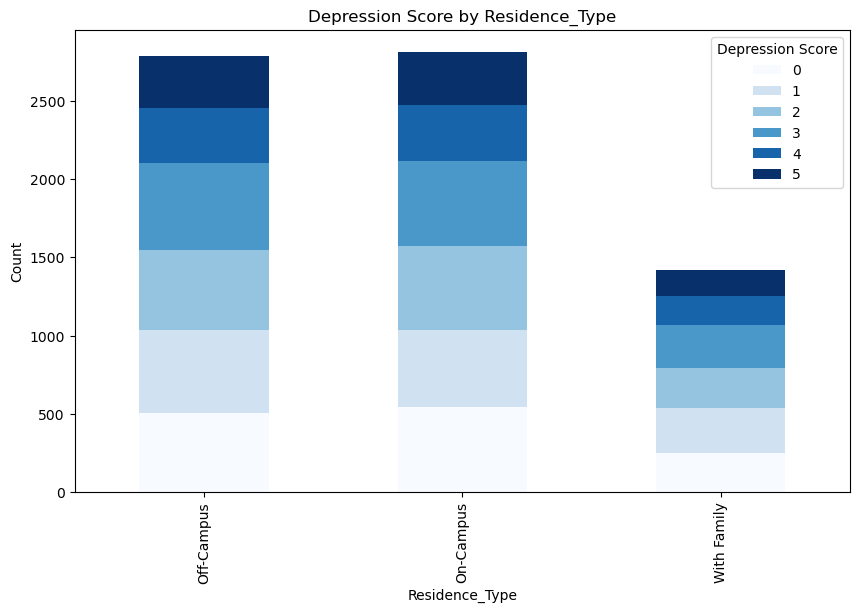

In [228]:
sleep_quality_counts = pd.crosstab(df['Residence_Type'], df['Depression_Score'])

# Plot stacked bar plot
sleep_quality_counts.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='Blues')
plt.title('Depression Score by Residence_Type')
plt.xlabel('Residence_Type')
plt.ylabel('Count')
plt.legend(title='Depression Score')
plt.savefig("../DATA1030_Project/figures/DEPRESSION_SCORE_BY_RESIDENCE_TYPE.png", dpi=300)
plt.show()

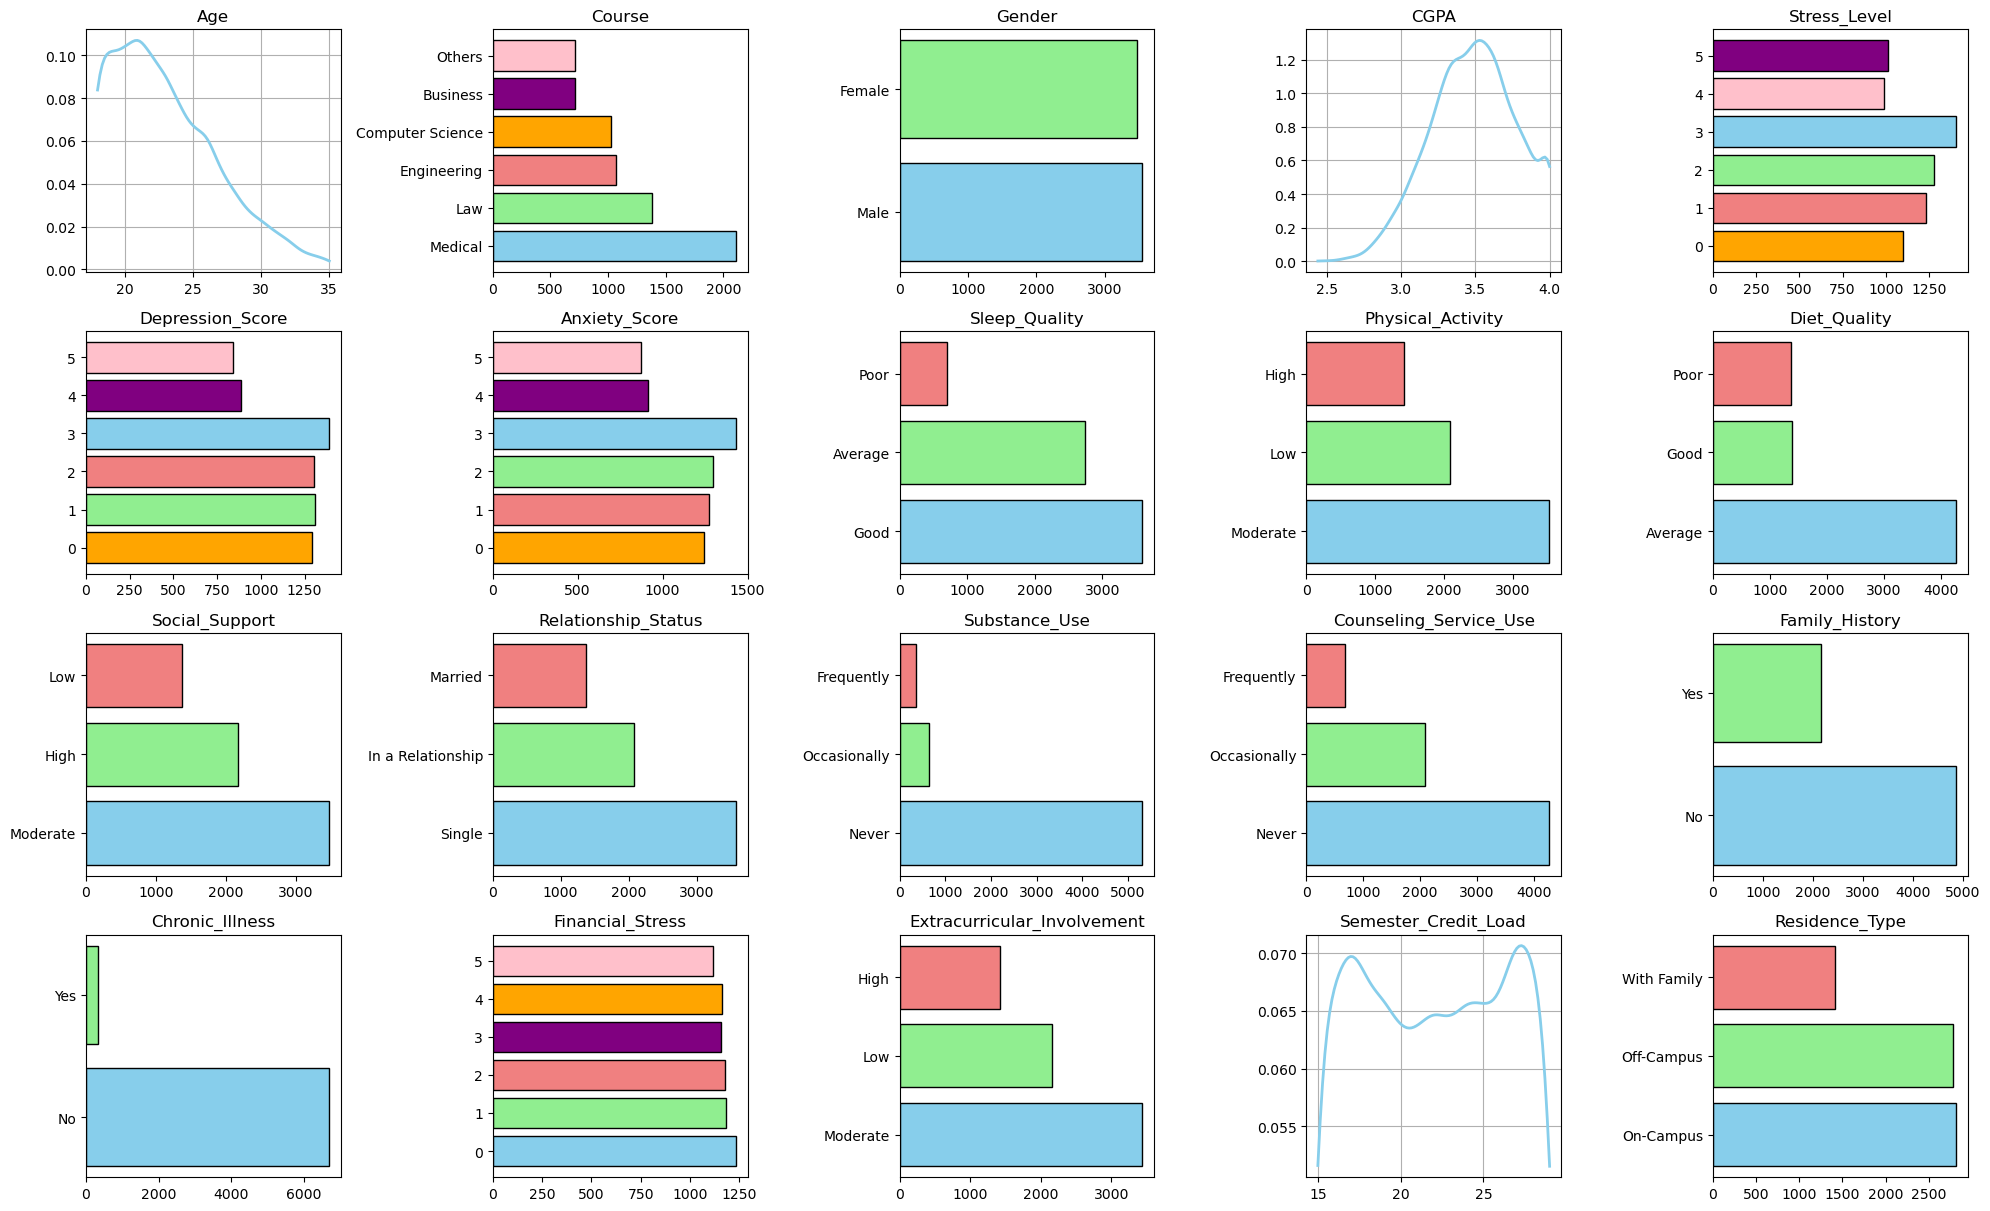

In [229]:
from scipy.stats import gaussian_kde

r = 5
c = 5
it = 1
plt.figure(figsize=(20, 15))

for i, j in enumerate(df.columns):
    plt.subplot(r, c, it)   
    if (df[j].dtype == 'object') or (j in ['Depression_Score', 'Anxiety_Score', 'Stress_Level', 'Financial_Stress']):
        value_counts = df[j].value_counts()
        colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'purple', 'pink']
        plt.barh(value_counts.index, value_counts.values, color=colors[:len(value_counts)], edgecolor='black')
        plt.title(j)
    
    else:
        col_clean = df[j].dropna()
        kde = gaussian_kde(col_clean)
        x_values = np.linspace(col_clean.min(), col_clean.max(), 100)
        plt.plot(x_values, kde(x_values), color='skyblue', lw=2)
        plt.title(j)
        plt.grid(True)    
    it += 1
    if it > r * c:
        break

plt.tight_layout()
plt.savefig("../DATA1030_Project/figures/overall_distribution_and_KDE_plot.png", dpi=300)
plt.show()

# Preprocessing

In [90]:
onehot_ftrs = ['Gender', 'Relationship_Status', 'Family_History', 'Chronic_Illness', 'Residence_Type'] 
minmax_ftrs = ['Age','CGPA', 'Semester_Credit_Load']
ordinal_ftrs = ['Stress_Level', 'Anxiety_Score', 'Financial_Stress', 'Sleep_Quality', 'Physical_Activity',
                 'Diet_Quality', 'Social_Support', 'Substance_Use', 'Counseling_Service_Use', 'Extracurricular_Involvement']
ordinal_cats = [
    [0, 1, 2, 3, 4, 5],  # Stress_Level
    [0, 1, 2, 3, 4, 5],  # Anxiety_Score
    [0, 1, 2, 3, 4, 5],  # Financial_Stress
    ['Poor', 'Average', 'Good'],  # Sleep_Quality
    ['Low', 'Moderate', 'High'],  # Physical_Activity
    ['Poor', 'Average', 'Good'],  # Diet_Quality
    ['Low', 'Moderate', 'High'],  # Social_Support
    ['Never', 'Occasionally', 'Frequently'],  # Substance_Use
    ['Never', 'Occasionally', 'Frequently'],  # Counseling_Service_Use
    ['Low', 'Moderate', 'High']  # Extracurricular_Involvement
]
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('ord', OrdinalEncoder(categories = ordinal_cats, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs)])
clf = Pipeline(steps=[('preprocessor', preprocessor)])


In [236]:
def MLpipe(X, y, groups, preprocessor, ML_algo, param_grid):

    # lists to be returned 
    test_scores = []
    best_models = []
    results = []
    y_test_preds = []
    y_tests = []
    X_tests = []
    grids = []

    random_states = range(5,30,5)
    
    for random_state in random_states:
        print('randoms state '+str(random_state))
        # Step 1: Splitting the data into other/test sets using GroupShuffleSplit (80-20)
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
        for i_other,i_test in splitter.split(X, y, groups):
            X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
            X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]

        # Step 2: Set up the GroupKFold with 3 splits for the cv
        kf = GroupKFold(n_splits = 3)

        # Step 3: Set up the pipeline for the preprocessing and ML models
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', ML_algo)
        ])

        # Step 4: Set up GridSearchCV for hyperparameter tuning
        grid = GridSearchCV(pipeline,
                            param_grid=param_grid,
                            scoring = 'neg_root_mean_squared_error',
                            cv=kf.split(X_other, y_other, groups_other),
                            return_train_score = True,
                            n_jobs=-1)

        # Step 5: Fit the GridSearchCV and find the best parameter
        grid.fit(X_other, y_other)

        # Save the best model, score, and its parameters
        best_model = grid.best_estimator_
        
        best_models.append(best_model)

        # Step 6: Evaluate the best model on the test set
        y_test_pred = best_model.predict(X_test)
        y_test_preds.append(y_test_pred)
        y_tests.append(y_test)
        X_tests.append(X_test)

        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_scores.append(test_rmse)
        result = pd.DataFrame(grid.cv_results_)
        results.append(result)
        grids.append(grid)
        
    return test_scores, best_models, results, y_test_preds, y_tests, X_tests, grids

In [260]:
#For models that can not hanld the missing continuous values, we simply drop the missing rows to avoid imputation.
df_cleaned = df.dropna(subset=["CGPA"])
X = df_cleaned.drop(columns = ['Depression_Score'])
y = df_cleaned['Depression_Score']
groups = df_cleaned['Course']
test_results_dic = {'ml_models':[], 'mean_test_scores': [], 'std_test_scores': []}

In [238]:
# Use linearRegression model as baseline model
lr_model = LinearRegression()
lr_param_grid = {}
lr_test_scores, lr_best_models, lr_results, lr_y_test_preds, lr_y_tests, lr_X_tests, lr_grids = MLpipe(X, y, groups, preprocessor, lr_model, lr_param_grid)

randoms state 5


randoms state 10
randoms state 15
randoms state 20
randoms state 25


In [261]:
lr_mean_test_score = np.mean(lr_test_scores)
lr_std_test_score = np.std(lr_test_scores)
test_results_dic['ml_models'].append('LinearRegression')
test_results_dic['mean_test_scores'].append(lr_mean_test_score)
test_results_dic['std_test_scores'].append(lr_std_test_score)

lr_mean_test_score, lr_std_test_score

(1.6201485873978587, 0.035455634538709146)

In [241]:
en_model = ElasticNet(max_iter=10000000)
en_param_grid = {
    'model__alpha': [0.01, 0.1, 0.5, 1, 2, 5, 10, 100],
    'model__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]
}
en_test_scores, en_best_models, en_results, en_y_test_preds, en_y_tests, en_X_tests, en_grids = MLpipe(X, y, groups, preprocessor, en_model, en_param_grid)

randoms state 5
randoms state 10
randoms state 15
randoms state 20
randoms state 25


In [262]:
en_mean_test_score = np.mean(en_test_scores)
en_std_test_score = np.std(en_test_scores)
test_results_dic['ml_models'].append('ElasticNet')
test_results_dic['mean_test_scores'].append(en_mean_test_score)
test_results_dic['std_test_scores'].append(en_std_test_score)

en_mean_test_score, en_std_test_score

(1.6134746302351117, 0.037585381873082906)

In [243]:
sorted_results = en_results[0].sort_values(by='mean_test_score', ascending=False)
print(sorted_results[['params', 'mean_test_score']])

                                            params  mean_test_score
39     {'model__alpha': 100, 'model__l1_ratio': 1}        -1.668943
14     {'model__alpha': 0.5, 'model__l1_ratio': 1}        -1.668943
25     {'model__alpha': 5, 'model__l1_ratio': 0.1}        -1.668943
24       {'model__alpha': 2, 'model__l1_ratio': 1}        -1.668943
23     {'model__alpha': 2, 'model__l1_ratio': 0.9}        -1.668943
22     {'model__alpha': 2, 'model__l1_ratio': 0.7}        -1.668943
21     {'model__alpha': 2, 'model__l1_ratio': 0.5}        -1.668943
28     {'model__alpha': 5, 'model__l1_ratio': 0.9}        -1.668943
19       {'model__alpha': 1, 'model__l1_ratio': 1}        -1.668943
18     {'model__alpha': 1, 'model__l1_ratio': 0.9}        -1.668943
17     {'model__alpha': 1, 'model__l1_ratio': 0.7}        -1.668943
16     {'model__alpha': 1, 'model__l1_ratio': 0.5}        -1.668943
29       {'model__alpha': 5, 'model__l1_ratio': 1}        -1.668943
13   {'model__alpha': 0.5, 'model__l1_ratio': 0.

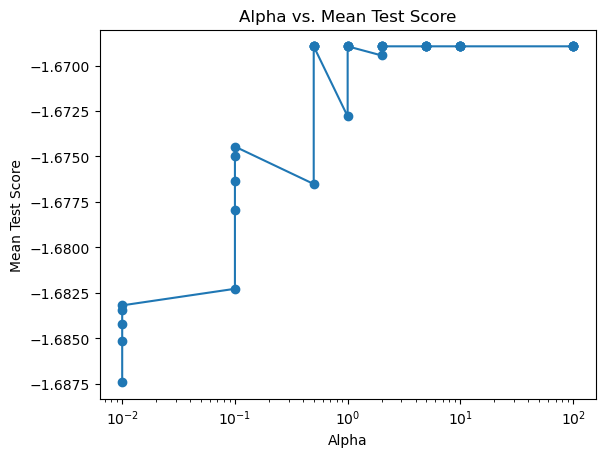

In [254]:
alpha_results = en_results[0]['param_model__alpha'].astype(float)
mean_scores = en_results[0]['mean_test_score']

# Plot mean_test_score vs. alpha
plt.plot(alpha_results, mean_scores, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.title('Alpha vs. Mean Test Score')
plt.xscale('log')  # Use log scale for wide-ranging parameters
plt.savefig("../DATA1030_Project/figures/check_en_grid.png", dpi=300)
plt.show()

In [112]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators = 100, random_state=42)
rf_param_grid = {
    'model__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],      # a
    'model__max_features': ['sqrt', 'log2']     # Number of features to consider at each split
}
rf_test_scores, rf_best_models, rf_results, rf_y_test_preds, rf_y_tests, rf_X_tests, rf_grids = MLpipe(X, y, groups, preprocessor, rf_model, rf_param_grid)

randoms state 5
randoms state 10
randoms state 15
randoms state 20
randoms state 25


In [263]:
rf_mean_test_score = np.mean(rf_test_scores)
rf_std_test_score = np.std(rf_test_scores)
test_results_dic['ml_models'].append('RandomForest')
test_results_dic['mean_test_scores'].append(rf_mean_test_score)
test_results_dic['std_test_scores'].append(rf_std_test_score)

rf_mean_test_score, rf_std_test_score

(1.6133364799758716, 0.0373277549651712)

In [247]:
sorted_results = rf_results[0].sort_values(by='mean_test_score', ascending=False)
print(sorted_results[['params', 'mean_test_score']])

                                               params  mean_test_score
1   {'model__max_depth': 1, 'model__max_features':...        -1.671688
0   {'model__max_depth': 1, 'model__max_features':...        -1.672104
3   {'model__max_depth': 2, 'model__max_features':...        -1.673568
2   {'model__max_depth': 2, 'model__max_features':...        -1.674376
5   {'model__max_depth': 3, 'model__max_features':...        -1.674473
7   {'model__max_depth': 4, 'model__max_features':...        -1.676094
4   {'model__max_depth': 3, 'model__max_features':...        -1.676893
6   {'model__max_depth': 4, 'model__max_features':...        -1.677383
9   {'model__max_depth': 5, 'model__max_features':...        -1.677601
11  {'model__max_depth': 6, 'model__max_features':...        -1.679805
10  {'model__max_depth': 6, 'model__max_features':...        -1.679828
8   {'model__max_depth': 5, 'model__max_features':...        -1.680106
13  {'model__max_depth': 7, 'model__max_features':...        -1.681439
12  {'

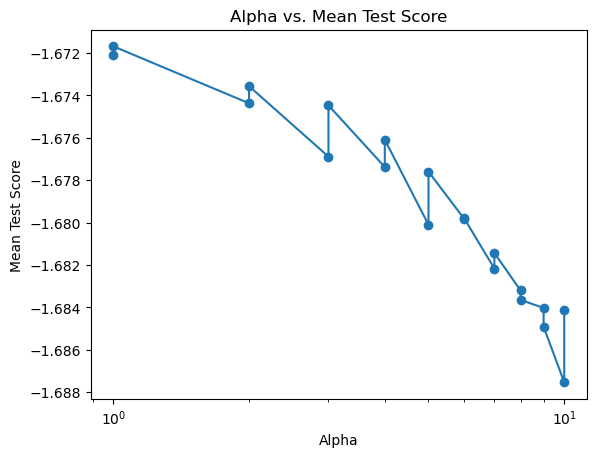

In [255]:
alpha_results = rf_results[0]['param_model__max_depth'].astype(float)
mean_scores = rf_results[0]['mean_test_score']

# Plot mean_test_score vs. alpha
plt.plot(alpha_results, mean_scores, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.title('Alpha vs. Mean Test Score')
plt.xscale('log')  # Use log scale for wide-ranging parameters
plt.savefig("../DATA1030_Project/figures/check_rf_grid.png", dpi=300)
plt.show()

In [116]:
knn_model = KNeighborsRegressor()

# Define the parameter grid for hyperparameter tuning
knn_param_grid = {
    'model__n_neighbors': [9, 11, 25, 100, 350, 400, 450],  # Number of neighbors
    'model__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'model__p': [1, 2]  # Power parameter for the Minkowski metric (1=Manhattan, 2=Euclidean)
}

# Use your MLpipe function to train and tune the KNN classifier
knn_test_scores, knn_best_models, knn_results, knn_y_test_preds, knn_y_tests, knn_X_tests, knn_grids = MLpipe(X, y, groups, preprocessor, knn_model, knn_param_grid)

randoms state 5
randoms state 10
randoms state 15
randoms state 20
randoms state 25


In [264]:
knn_mean_test_score = np.mean(knn_test_scores)
knn_std_test_score = np.std(knn_test_scores)
test_results_dic['ml_models'].append('KNN')
test_results_dic['mean_test_scores'].append(knn_mean_test_score)
test_results_dic['std_test_scores'].append(knn_std_test_score)

knn_mean_test_score, knn_std_test_score

(1.6125590995206327, 0.0375859263183634)

In [249]:
sorted_results = knn_results[0].sort_values(by='mean_test_score', ascending=False)
print(sorted_results[['params', 'mean_test_score']])

                                               params  mean_test_score
25  {'model__n_neighbors': 450, 'model__p': 1, 'mo...        -1.674077
24  {'model__n_neighbors': 450, 'model__p': 1, 'mo...        -1.674148
21  {'model__n_neighbors': 400, 'model__p': 1, 'mo...        -1.674294
20  {'model__n_neighbors': 400, 'model__p': 1, 'mo...        -1.674379
17  {'model__n_neighbors': 350, 'model__p': 1, 'mo...        -1.674873
16  {'model__n_neighbors': 350, 'model__p': 1, 'mo...        -1.675016
23  {'model__n_neighbors': 400, 'model__p': 2, 'mo...        -1.676824
22  {'model__n_neighbors': 400, 'model__p': 2, 'mo...        -1.676924
19  {'model__n_neighbors': 350, 'model__p': 2, 'mo...        -1.677353
27  {'model__n_neighbors': 450, 'model__p': 2, 'mo...        -1.677443
18  {'model__n_neighbors': 350, 'model__p': 2, 'mo...        -1.677495
26  {'model__n_neighbors': 450, 'model__p': 2, 'mo...        -1.677652
13  {'model__n_neighbors': 100, 'model__p': 1, 'mo...        -1.681308
15  {'

In [119]:
# SVM regression model
svm_model = SVR(kernel = 'linear')
svm_param_grid = {
    'model__C': [1e-2, 1e-1, 1e0, 1e1, 1e2],       # Regularization parameter
    'model__gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5] 
}
svm_test_scores, svm_best_models, svm_results, svm_y_test_preds, svm_y_tests, svm_X_tests, svm_grids = MLpipe(X, y, groups, preprocessor, svm_model, svm_param_grid)

randoms state 5
randoms state 10
randoms state 15
randoms state 20
randoms state 25


In [265]:
svm_mean_test_score = np.mean(svm_test_scores)
svm_std_test_score = np.std(svm_test_scores)
test_results_dic['ml_models'].append('SVM')
test_results_dic['mean_test_scores'].append(svm_mean_test_score)
test_results_dic['std_test_scores'].append(svm_std_test_score)

svm_mean_test_score, svm_std_test_score

(1.6120908927782593, 0.050386246729372905)

In [121]:
sorted_results = svm_results[0].sort_values(by='mean_test_score', ascending=False)
print(sorted_results[['params', 'mean_test_score']])

                                           params  mean_test_score
0       {'model__C': 0.01, 'model__gamma': 0.001}        -1.719719
2        {'model__C': 0.01, 'model__gamma': 10.0}        -1.719719
3      {'model__C': 0.01, 'model__gamma': 1000.0}        -1.719719
4    {'model__C': 0.01, 'model__gamma': 100000.0}        -1.719719
1         {'model__C': 0.01, 'model__gamma': 0.1}        -1.719719
7         {'model__C': 0.1, 'model__gamma': 10.0}        -1.721929
8       {'model__C': 0.1, 'model__gamma': 1000.0}        -1.721929
9     {'model__C': 0.1, 'model__gamma': 100000.0}        -1.721929
6          {'model__C': 0.1, 'model__gamma': 0.1}        -1.721929
5        {'model__C': 0.1, 'model__gamma': 0.001}        -1.721929
19   {'model__C': 10.0, 'model__gamma': 100000.0}        -1.723428
15      {'model__C': 10.0, 'model__gamma': 0.001}        -1.723428
16        {'model__C': 10.0, 'model__gamma': 0.1}        -1.723428
17       {'model__C': 10.0, 'model__gamma': 10.0}        -1.72

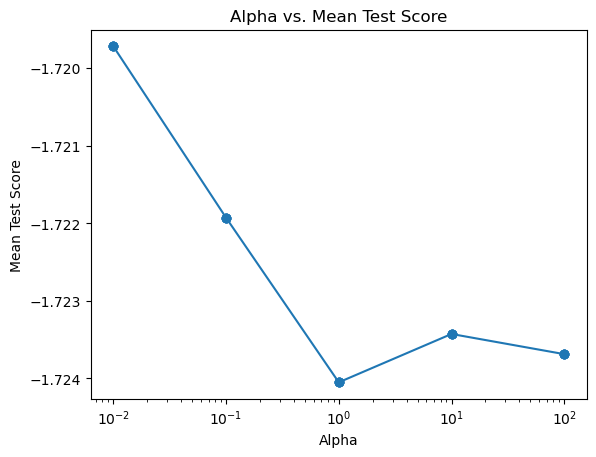

In [256]:
alpha_results = svm_results[0]['param_model__C'].astype(float)
mean_scores = svm_results[0]['mean_test_score']

# Plot mean_test_score vs. alpha
plt.plot(alpha_results, mean_scores, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score')
plt.title('Alpha vs. Mean Test Score')
plt.xscale('log')  # Use log scale for wide-ranging parameters
plt.savefig("../DATA1030_Project/figures/check_svm_grid.png", dpi=300)
plt.show()

In [167]:
# Since XGBoost can handle missing values we can use the uncleaned data for X and y
X = df.drop(columns = ['Depression_Score'])
y = df['Depression_Score']
groups = df['Course']

In [169]:
xgb_model = xgb.XGBRegressor()
xgb_param_grid = {"model__learning_rate": [0.03],
              "model__n_estimators": [200],
              "model__seed": [0],
              "model__reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "model__reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "model__missing": [np.nan], 
              "model__max_depth": [1,3,10,30,100],
              "model__colsample_bytree": [0.9],              
              "model__subsample": [0.66]}
xgb_test_scores, xgb_best_models, xgb_results, xgb_y_test_preds, xgb_y_tests, xgb_X_tests, xgb_grids = MLpipe(X, y, groups, preprocessor, xgb_model, xgb_param_grid)

randoms state 5


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


randoms state 10


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


randoms state 15


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


randoms state 20


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


randoms state 25


/opt/anaconda3/envs/data1030/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [266]:
xgb_mean_test_score = np.mean(xgb_test_scores)
xgb_std_test_score = np.std(xgb_test_scores)
test_results_dic['ml_models'].append('XGB')
test_results_dic['mean_test_scores'].append(xgb_mean_test_score)
test_results_dic['std_test_scores'].append(xgb_std_test_score)

xgb_mean_test_score, xgb_std_test_score

(1.6196485900983124, 0.03942407033388635)

In [251]:
sorted_results = xgb_results[0].sort_values(by='mean_test_score', ascending=False)
print(sorted_results[['params', 'mean_test_score']])

                                               params  mean_test_score
35  {'model__colsample_bytree': 0.9, 'model__learn...        -1.684507
34  {'model__colsample_bytree': 0.9, 'model__learn...        -1.684681
30  {'model__colsample_bytree': 0.9, 'model__learn...        -1.684692
33  {'model__colsample_bytree': 0.9, 'model__learn...        -1.684694
32  {'model__colsample_bytree': 0.9, 'model__learn...        -1.684696
..                                                ...              ...
80  {'model__colsample_bytree': 0.9, 'model__learn...        -1.756688
79  {'model__colsample_bytree': 0.9, 'model__learn...        -1.756708
85  {'model__colsample_bytree': 0.9, 'model__learn...        -1.757493
84  {'model__colsample_bytree': 0.9, 'model__learn...        -1.757656
72  {'model__colsample_bytree': 0.9, 'model__learn...        -1.759961

[180 rows x 2 columns]


In [267]:
value_counts = y.value_counts()
mean_y = (value_counts.index * value_counts).sum() / value_counts.sum()
baseline_pred = [mean_y] * len(y)
baseline_test_score = np.sqrt(mean_squared_error(y, baseline_pred))
test_results_dic['ml_models'].append('Baseline')
test_results_dic['mean_test_scores'].append(baseline_test_score)
test_results_dic['std_test_scores'].append(0)
baseline_test_score

1.6172758064818922

In [276]:
test_results_df = pd.DataFrame(test_results_dic)
test_results_df = test_results_df.sort_values(by='mean_test_scores')
test_results_df['std_over_baseline'] = (baseline_test_score - test_results_df['mean_test_scores']) / test_results_df['std_test_scores']
test_results_df

,ml_models,mean_test_scores,std_test_scores,std_over_baseline
4,SVM,1.612091,0.050386,0.102903
3,KNN,1.612559,0.037586,0.125491
2,RandomForest,1.613336,0.037328,0.105533
1,ElasticNet,1.613475,0.037585,0.101134
6,Baseline,1.617276,0.000000,NaN
5,XGB,1.619649,0.039424,-0.060186
0,LinearRegression,1.620149,0.035456,-0.081025


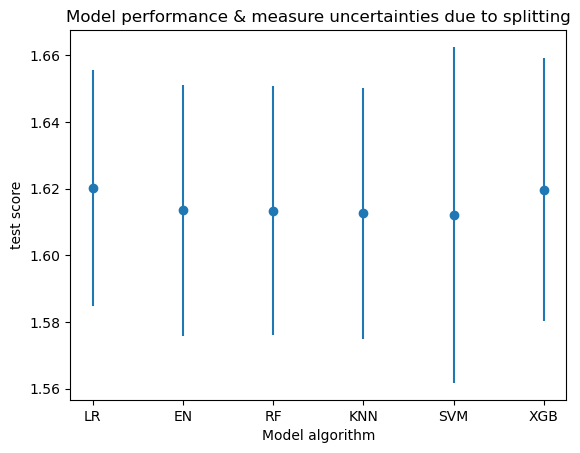

In [272]:
model_means = [np.mean(lr_test_scores), np.mean(en_test_scores), np.mean(rf_test_scores),np.mean(knn_test_scores), \
               np.mean(svm_test_scores),np.mean(xgb_test_scores)]
model_strs = [np.std(lr_test_scores), np.std(en_test_scores), np.std(rf_test_scores),np.std(knn_test_scores), \
               np.std(svm_test_scores),np.std(xgb_test_scores)]
plt.errorbar(['LR', 'EN', 'RF', 'KNN', 'SVM', 'XGB'], model_means, yerr=model_strs, fmt='o')
plt.title('Model performance & measure uncertainties due to splitting')
plt.xlabel('Model algorithm')
plt.ylabel('test score')
plt.savefig("../DATA1030_Project/figures/model_performance.png", dpi=300)
plt.show()

In [293]:
svm_test_scores

[1.5805358584385405,
 1.5805358584385405,
 1.587671909680919,
 1.7118709286840774,
 1.5998399086492188]

In [294]:
df_cleaned = df.dropna(subset=["CGPA"])
X = df_cleaned.drop(columns = ['Depression_Score'])
y = df_cleaned['Depression_Score']
groups = df_cleaned['Course']
y_pred = svm_y_test_preds[np.argmin(svm_test_scores)]
y_true = svm_y_tests[np.argmin(svm_test_scores)]
y_pred

array([2.09996073, 2.10114852, 2.10057278, ..., 2.10013182, 2.1001532 ,
       2.09995498])

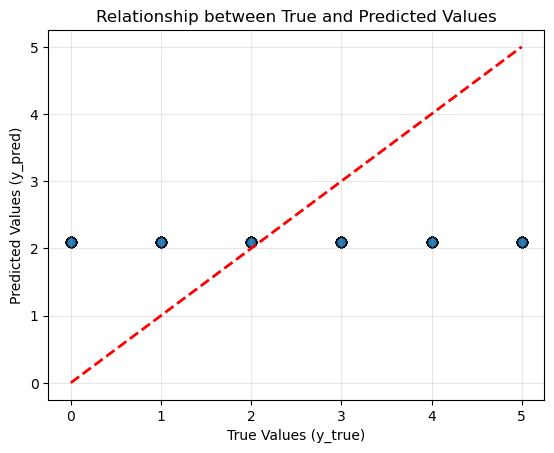

In [295]:
plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k', s=50)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Line y=x
plt.xlabel('True Values (y_true)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Relationship between True and Predicted Values')
plt.grid(alpha=0.3)
plt.show()

In [296]:
#Extract all necessary data set and model for future feature importance analysis
best_model = svm_best_models[np.argmin(svm_test_scores)]
y_test = svm_y_tests[np.argmin(svm_test_scores)]
grid = svm_grids[np.argmin(svm_test_scores)]
feature_names = grid.best_estimator_[0].get_feature_names_out()
X_test = svm_X_tests[np.argmin(svm_test_scores)]
X_test_transformed = best_model[0].transform(X_test)
df_test = pd.DataFrame(data=X_test_transformed,columns = feature_names)

In [318]:
import pickle
pickle.dump(best_model, open('../DATA1030_Project/results/model.pkl', 'wb'))

In [319]:
y_pred = svm_y_test_preds[np.argmin(svm_test_scores)]
prediction = pd.DataFrame(y_pred, columns = ['predictions']).to_csv('../DATA1030_Project/results/prediction.csv')

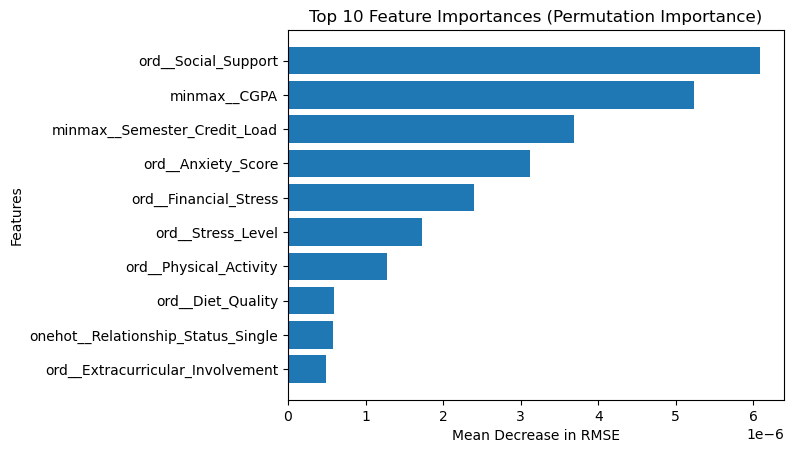

In [297]:
#Permutation Importance
import warnings
warnings.filterwarnings("ignore")
result = permutation_importance(best_model.named_steps['model'], df_test, y_test, n_repeats=10,
                                random_state=42)

importances = result.importances_mean
sorted_indices = np.argsort(importances)[::-1]

top_10_indices = sorted_indices[:10]
top_10_features = feature_names[top_10_indices]
top_10_importances = importances[top_10_indices]
plt.barh(top_10_features[::-1], top_10_importances[::-1], align='center')
plt.xlabel('Mean Decrease in RMSE')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances (Permutation Importance)')
plt.savefig("../DATA1030_Project/figures/Permutation_importance.png", dpi=300)
plt.show()

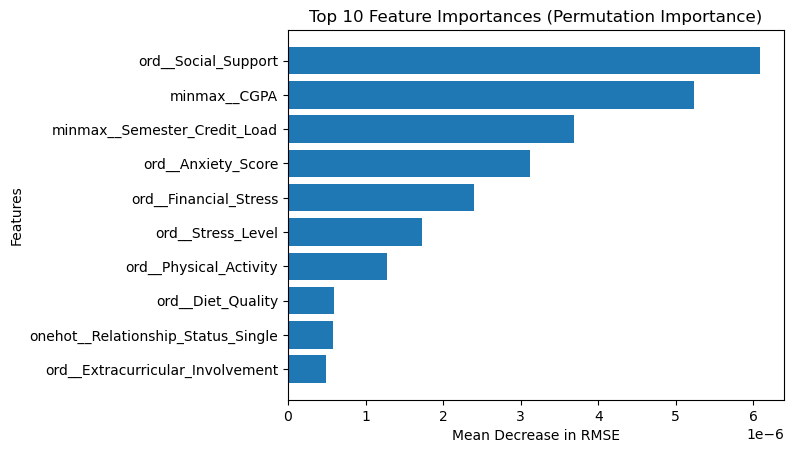

In [301]:
top_10_indices = sorted_indices[:10]
top_10_features = feature_names[top_10_indices]
top_10_importances = importances[top_10_indices]
plt.barh(top_10_features[::-1], top_10_importances[::-1], align='center')
plt.xlabel('Mean Decrease in RMSE')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances (Permutation Importance)')
plt.savefig("../DATA1030_Project/figures/Permutation_importance.png", dpi=500, bbox_inches='tight')
plt.show()

In [187]:
best_model[1]

SVR(C=0.01, gamma=0.001, kernel='linear')

In [304]:
#CV pipeline with standard scaled feature weights
def Scaled_MLpipe(X, y, groups, preprocessor, ML_algo, param_grid):

    # lists to be returned 
    test_scores = []
    best_models = []
    results = []
    y_test_preds = []
    y_tests = []
    X_tests = []
    grids = []

    random_states = range(5,30,5)
    
    for random_state in random_states:
        print('randoms state '+str(random_state))
        # Step 1: Splitting the data into other/test sets using GroupShuffleSplit (80-20)
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
        for i_other,i_test in splitter.split(X, y, groups):
            X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
            X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]

        # Step 2: Set up the GroupKFold with 3 splits for the cv
        kf = GroupKFold(n_splits = 3)

        # Step 3: Set up the pipeline for the preprocessing and ML models
        final_scaler = StandardScaler()
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('standard', final_scaler),
            ('model', ML_algo)
        ])

        # Step 4: Set up GridSearchCV for hyperparameter tuning
        grid = GridSearchCV(pipeline,
                            param_grid=param_grid,
                            scoring = 'neg_root_mean_squared_error',
                            cv=kf.split(X_other, y_other, groups_other),
                            return_train_score = True,
                            n_jobs=-1)

        # Step 5: Fit the GridSearchCV and find the best parameter
        grid.fit(X_other, y_other)

        # Save the best model, score, and its parameters
        best_model = grid.best_estimator_
        best_param = grid.best_params_
        best_score = grid.best_score_
        
        best_models.append(best_model)

        # Step 6: Evaluate the best model on the test set
        y_test_pred = best_model.predict(X_test)
        y_test_preds.append(y_test_pred)
        y_tests.append(y_test)
        X_tests.append(X_test)

        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_scores.append(test_rmse)
        result = pd.DataFrame(grid.cv_results_)
        results.append(result)
        grids.append(grid)
        
    return test_scores, best_models, results, y_test_preds, y_tests, X_tests, grids

In [305]:
svm_model = SVR(kernel = 'linear')
svm_param_grid = {
    'model__C': [1e-2, 1e-1, 1e0, 1e1, 1e2],       # Regularization parameter
    'model__gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5] 
}
svm_scaled_test_scores, svm_scaled_best_models, svm_scaled_results, svm_scaled_y_test_preds, svm_scaled_y_tests, svm_scaled_X_tests, svm_scaled_grids = MLpipe(X, y, groups, preprocessor, svm_model, svm_param_grid)

randoms state 5
randoms state 10
randoms state 15
randoms state 20
randoms state 25


In [306]:
# Get all necessary datasets and grid from feature weight scaled data
scaled_X_test = svm_scaled_X_tests[np.argmin(svm_scaled_test_scores)]
scaled_grid = svm_scaled_grids[np.argmin(svm_scaled_test_scores)]
scaled_y_test = svm_scaled_y_tests[np.argmin(svm_scaled_test_scores)]
scaled_feature_names = scaled_grid.best_estimator_[0].get_feature_names_out()


test score: -1.5805358584385405


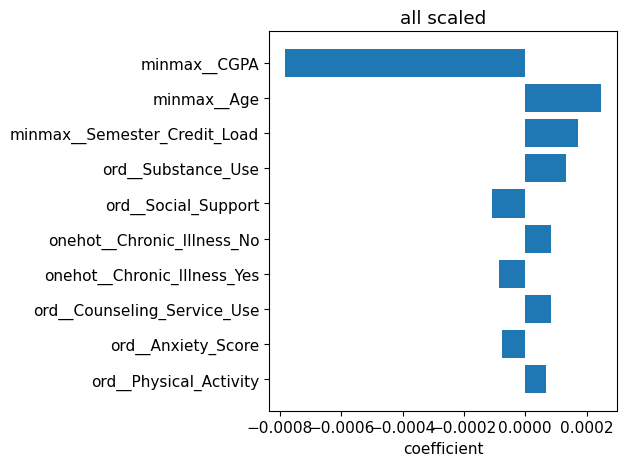

In [307]:
print('test score:',scaled_grid.score(scaled_X_test,scaled_y_test))
coefs = scaled_grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))
plt.rcParams.update({'font.size': 11})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),scaled_feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
plt.savefig("../DATA1030_Project/figures/linear_coefficients.png", dpi=300, bbox_inches='tight')
plt.show()

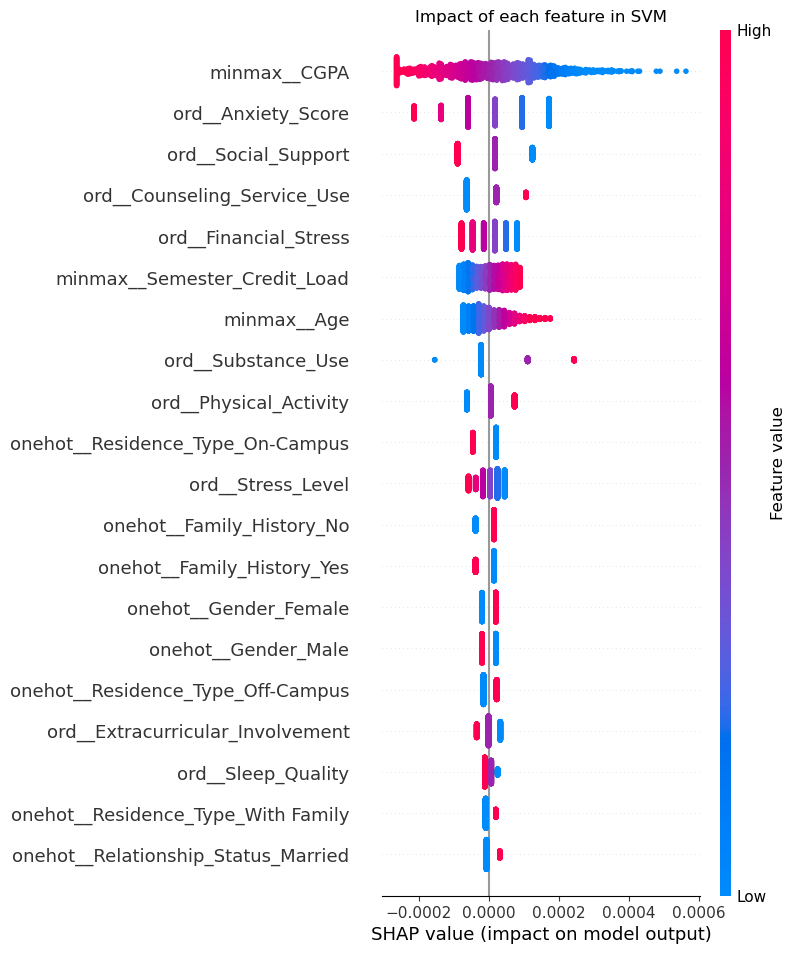

In [188]:
# SHAP for Global feature importance
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.LinearExplainer(best_model.named_steps['model'], df_test)
shap_values = explainer.shap_values(df_test)
shap.summary_plot(shap_values, df_test, show=False)
fig = plt.gcf()
ax = plt.gca()
ax.set_title("Impact of each feature in SVM")
plt.savefig("../DATA1030_Project/figures/SHAP_global.png", dpi=300)

plt.show()

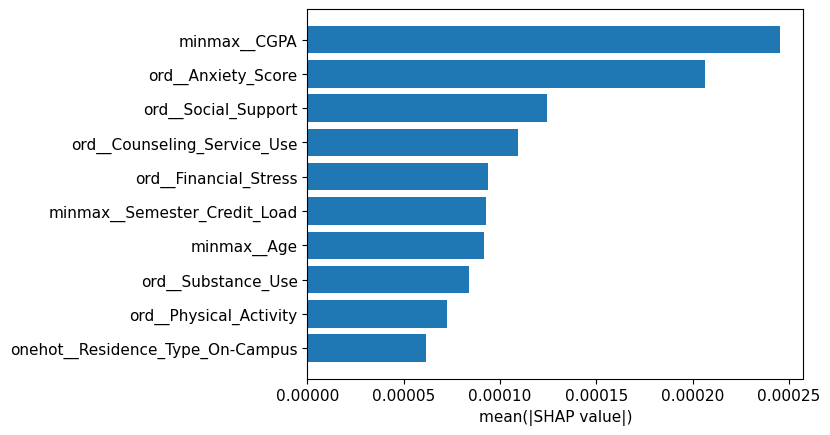

In [308]:
shap_summary = np.mean(np.abs(shap_values[:,:]),axis=0)+np.mean(np.abs(shap_values[:,:]),axis=0) # same shape as the number of features
indcs = np.argsort(shap_summary)
shap_summary[indcs]

plt.barh(feature_names[indcs[-10:]],shap_summary[indcs[-10:]])
plt.xlabel('mean(|SHAP value|)')
plt.savefig("../DATA1030_Project/figures/SHAP_global_2.png", dpi=300, bbox_inches='tight')

plt.show()

2.1000648428333606


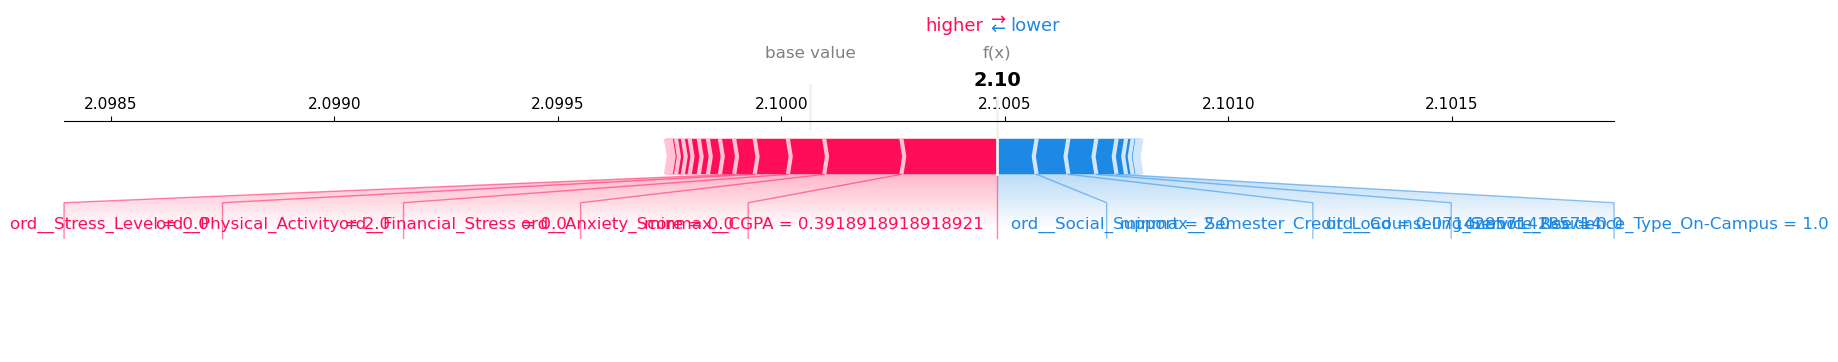

In [317]:
index = 20
print(explainer.expected_value)
shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test_transformed[index,:],feature_names = feature_names, matplotlib=True)
plt.close()


In [313]:
index = 20
print(explainer.expected_value)
shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test_transformed[index,:],feature_names = feature_names, show=False, matplotlib=True).savefig('force_1.png')
plt.close()

2.1000648428333606


In [314]:
index = 35
print(explainer.expected_value)
shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test_transformed[index,:],feature_names = feature_names, show=False, matplotlib=True).savefig('force_2.png')
plt.close()


2.1000648428333606


2.1000648428333606


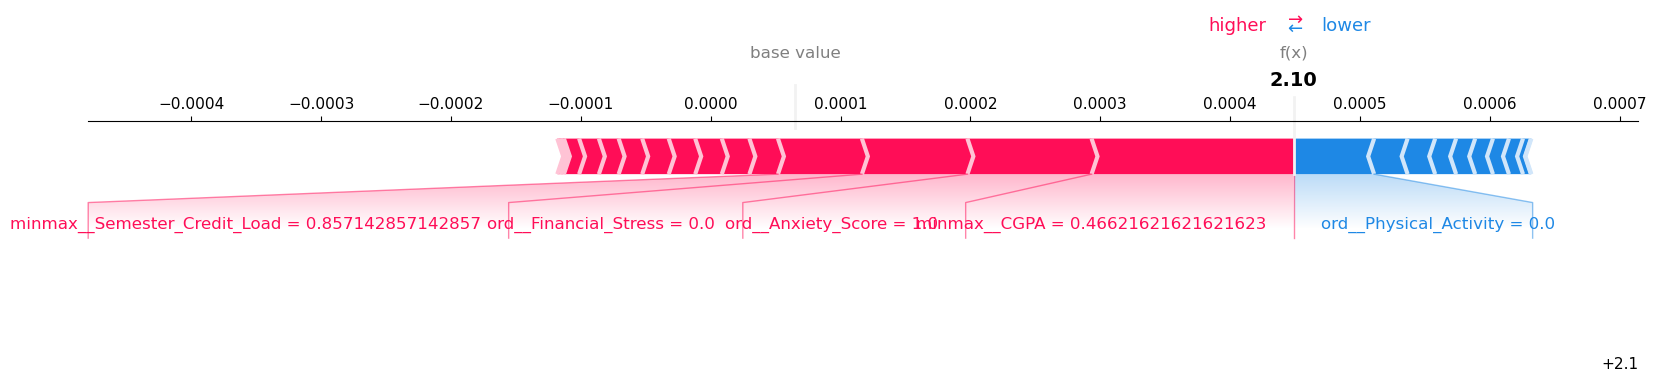

In [315]:
index = 35
print(explainer.expected_value)
shap.force_plot(explainer.expected_value, shap_values[index,:], features = X_test_transformed[index,:],feature_names = feature_names, matplotlib=True)
plt.close()